In [1]:
import numpy as np
import coffea
import awkward as ak
from coffea.nanoaod import NanoEvents
from coffea import processor, hist
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
fname = "/Users/herwig/Desktop/dominic/data/met100_skim.root"
events = NanoEvents.from_file(fname)

Can directly get the objects and check their properties

In [3]:
# truth collections
truth_n2 = events.GenPart[
    (events.GenPart.pdgId == 1000023)
    & events.GenPart.hasFlags(['isLastCopy'])
]
truth_n1 = events.GenPart[
    (events.GenPart.pdgId == 1000022)
    & (events.GenPart.parent.pdgId == 1000023)
    & events.GenPart.hasFlags(['isLastCopy'])
]
truth_ele_mask = (abs(events.GenPart.pdgId) == 11) & events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])
truth_eles = events.GenPart[truth_ele_mask]

dM = truth_n2.mass-truth_n1.mass
mask = truth_eles.counts==2
ee_events = truth_eles[mask]
dM = dM[mask]
ee=ee_events[:,0]+ee_events[:,1]
ee.mass [ (dM<2)[:,0] ]


/Users/herwig/miniconda3/envs/coffea/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


array([0.7674082 , 0.8898775 , 0.64670414, ..., 0.8615264 , 0.6542648 ,
       0.46107867], dtype=float32)

Do the full analysis in a processor

In [311]:
class TruthAna(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "N2-N1 mass difference")
        mass_axis = hist.Bin("mass", r"$m_{ee}$ [GeV]", 40, 0, 4)
        pt_axis = hist.Bin("pt", r"$p_{T,e}$ [GeV]", 40, 0, 8)
        pt_axis_sm = hist.Bin("pt", r"$p_{T,e}$ [GeV]", 15, 0.5, 2)
        lead_pt_axis = hist.Bin("pt", r"$p_{T,e1}$ [GeV]", 40, 0, 8)
        sub_pt_axis = hist.Bin("pt", r"$p_{T,e2}$ [GeV]", 40, 0, 4)
        ratio_axis = hist.Bin("ratio", r"$p_{T,reco}/p_{T,truth}$ [GeV]", 40, 0, 2)
        
        self.selections = {
            "prompt" : lambda x: (np.abs(x.dz) < 0.2) & (x.sip3d < 3),
            "loose" : lambda x: (np.abs(x.dz) < 0.2) & (x.sip3d < 3) & (x.mvaId>3),
        }
        self.selections["eff70"]=None
        self.selections["eff80"]=None
        self.selections["eff90"]=None
        
        hists = {
            # truth
            'mass': hist.Hist("Counts", dataset_axis, mass_axis),
            'pt_lead': hist.Hist("Counts", dataset_axis, lead_pt_axis),
            'pt_sub': hist.Hist("Counts", dataset_axis, sub_pt_axis),
            'pt_rel': hist.Hist("Counts", dataset_axis, lead_pt_axis, ratio_axis),

            # Efficiencies: for reco analysis, binned in truth pt
            'pt_all_truth': hist.Hist("Counts", dataset_axis, pt_axis),
            'pt_all_truth_matched': hist.Hist("Counts", dataset_axis, pt_axis),
            'pt_all_truth_sm': hist.Hist("Counts", dataset_axis, pt_axis_sm),
            'pt_all_truth_matched_sm': hist.Hist("Counts", dataset_axis, pt_axis_sm),

            # Fake rates: for reco analysis, binned in reco pt
            'pt_all_reco_unmatched': hist.Hist("Counts", dataset_axis, pt_axis),

            # unused for now
            'cutflow': processor.defaultdict_accumulator(int),
        }
        for sel in self.selections:
            hs = {
                #efficiencies
                sel+'_pt_all_truth_selected': hist.Hist("Counts", dataset_axis, pt_axis),
                sel+'_pt_all_truth_selected_sm': hist.Hist("Counts", dataset_axis, pt_axis_sm),
                # Fake rates
                sel+'_pt_all_selected_unmatched': hist.Hist("Counts", dataset_axis, pt_axis),   
            }
            hists.update(hs)
            
        self._accumulator = processor.dict_accumulator(hists)

    @property
    def accumulator(self):
        return self._accumulator

    
    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        out = self.accumulator.identity()
        
        truth_n2 = events.GenPart[ (events.GenPart.pdgId == 1000023)
            & events.GenPart.hasFlags(['isLastCopy'])]
        truth_n1 = events.GenPart[(events.GenPart.pdgId == 1000022)
            & (events.GenPart.parent.pdgId == 1000023)
            & events.GenPart.hasFlags(['isLastCopy'])]
        truth_ele_mask = (abs(events.GenPart.pdgId) == 11) & events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])
        all_truth_eles = events.GenPart[truth_ele_mask]
        # calc dM
        dM = truth_n2.mass-truth_n1.mass
        # get ee events
        event_mask = (all_truth_eles.counts==2)
        dM = dM[event_mask]
        truth_eles = all_truth_eles[event_mask]
        ee = truth_eles[:,0]+truth_eles[:,1]
        lead = truth_eles[truth_eles.pt.argmax()]
        sublead = truth_eles[truth_eles.pt.argmin()]
        

        #match truth_eles
        reco_sel = events.ElectronBPark.isLowPt #& (~events.ElectronBPark.isPFoverlap)
        reco_eles = events.ElectronBPark[reco_sel]
        reco_eles_prematched = reco_eles[reco_eles.genPartIdx >=0] #nb not final truth-match
        reco_eles_unmatched = reco_eles[reco_eles.genPartIdx <0]
        # apply event masks
        reco_eles = events.ElectronBPark[event_mask]
        reco_eles_prematched = reco_eles_prematched[event_mask]
        reco_eles_unmatched = reco_eles_unmatched[event_mask]
        # custom truth-match
        tr_pairs = truth_eles.cross(reco_eles_prematched, nested=True)
        t, r = tr_pairs.unzip()
        drs = t.delta_r(r)
        idx = drs.argmin()
        r_match = tr_pairs.i1[idx[drs[idx] < 0.05]].flatten(1)
        t_match = tr_pairs.i0[idx[drs[idx] < 0.05]].flatten(1)
        #should be left with only one pairing given the right dR cut

        # Constant-efficiency mvaId cuts
        r_prompt = r_match[ self.selections["prompt"](r_match) ]
        mva_pt_bins = np.linspace(0.5,4,15) # 0.25 GeV
        WPs = ["0.70","0.80","0.90"]
        # determine the thresholds
        r_flat = r_prompt.flatten()
        binned = np.digitize(r_flat.pt, mva_pt_bins)
        binned_scores=[]
        for ib,_ in enumerate(mva_pt_bins):
            sorted_scores = r_flat.mvaId[(binned == (ib+1))]
            sorted_scores.sort()
            binned_scores.append( sorted_scores )
        self.thresholds={}
        for wp in WPs:
            wpval = 1. - float(wp) #since e.g. eff90 rejects 10%
            cut_vals = [scores[ int(wpval*len(scores)) ] for scores in binned_scores]
            self.thresholds[wp]=np.array([-9e99]+cut_vals) #no cut for (empty) zero bin


        # record separately for each dM value        
        isDM1 = (dM<2)[:,0]
        subsets={'dM1': isDM1,'dM3': ~isDM1}

        # fill all distributions
        for tag, rule in subsets.items():
            out['cutflow'][tag] += rule.sum()
            
            # Truth analysis
            out["mass"].fill( dataset=tag, mass=ee[rule].mass.flatten())
            out["pt_lead"].fill(dataset=tag, pt=lead[rule].pt.flatten())
            out["pt_sub"].fill(dataset=tag, pt=sublead[rule].pt.flatten())
            
            
            # Reco efficiencies, binned in truth pt
            out['pt_all_truth'].fill(dataset=tag, pt=truth_eles[rule].pt.flatten())
            out['pt_all_truth_matched'].fill(dataset=tag, pt=t_match[rule].pt.flatten())
            out['pt_all_truth_sm'].fill(dataset=tag, pt=truth_eles[rule].pt.flatten())
            out['pt_all_truth_matched_sm'].fill(dataset=tag, pt=t_match[rule].pt.flatten())
            # Fake rates: for reco analysis, binned in reco pt
            out['pt_all_reco_unmatched'].fill(dataset=tag, pt=reco_eles_unmatched[rule].pt.flatten())
            # pT resolution
            rat = np.divide(r_match[rule].pt.flatten(),t_match[rule].pt.flatten())
            out['pt_rel'].fill(dataset=tag, pt=t_match[rule].pt.flatten(), ratio=rat)

            
            # Loop over selections to study
            for seltag, sel in self.selections.items():
                if not sel: continue
                id_mask = sel(r_match)
                t_match_sel = t_match[id_mask]
                #r_match_sel = r_match[id_mask] #unused
                reco_unmatched_sel = reco_eles_unmatched[ sel(reco_eles_unmatched) ]
                # fill
                out[seltag+'_pt_all_truth_selected'].fill(dataset=tag, pt=t_match_sel[rule].pt.flatten())
                out[seltag+'_pt_all_truth_selected_sm'].fill(dataset=tag, pt=t_match_sel[rule].pt.flatten())
                out[seltag+'_pt_all_selected_unmatched'].fill(dataset=tag, pt=reco_unmatched_sel[rule].pt.flatten())
                
            for wp in self.thresholds:
                threhsolds = self.thresholds[wp]
                flat = r_match[rule].flatten()
                binned = np.digitize(flat.pt, mva_pt_bins)
                id_mask = (flat.mvaId > threhsolds[binned])
                flat = flat[id_mask]
                #flat.pt[id_mask] # fill histos with this
                seltag = "eff"+wp.split('.')[-1]
                out[seltag+'_pt_all_truth_selected'].fill(dataset=tag, pt=flat.pt)
                out[seltag+'_pt_all_truth_selected_sm'].fill(dataset=tag, pt=flat.pt)
                # unmatched
                flat = reco_unmatched_sel[rule].flatten()
                binned = np.digitize(flat.pt, mva_pt_bins)
                flat = flat[(flat.mvaId > threhsolds[binned])]
                out[seltag+'_pt_all_selected_unmatched'].fill(dataset=tag, pt=flat.pt)

            
        return out

    def postprocess(self, accumulator):
        return accumulator

In [312]:
samples = { "N2N1": [fname] }

result = processor.run_uproot_job(
    samples,
    "Events",
    TruthAna(),
    processor.iterative_executor,
    {"nano": True},
)
# postproc
selections=['prompt','loose']
selections+=['eff70','eff80','eff90']
n1 = result['cutflow']['dM1']
n3 = result['cutflow']['dM3']
result["pt_all_reco_unmatched"].scale({'dM1': 1./n1, 'dM3': 1./n3}, axis='dataset')
for sel in selections:
    result[sel+"_pt_all_selected_unmatched"].scale({'dM1': 1./n1, 'dM3': 1./n3}, axis='dataset')




In [313]:
result['cutflow']

defaultdict_accumulator(int, {'dM1': 7892, 'dM3': 6389})

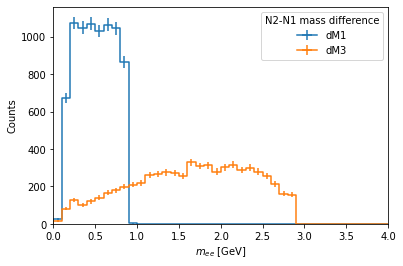

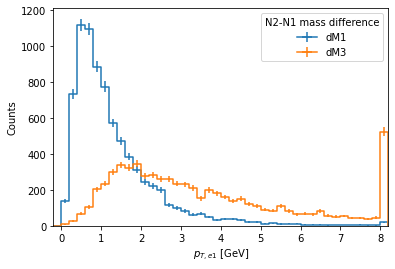

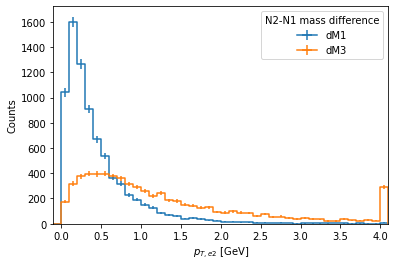

In [314]:
plt.figure()
hist.plot1d(result["mass"])
plt.figure()
hist.plot1d(result["pt_lead"],overflow='all')
plt.figure()
hist.plot1d(result["pt_sub"],overflow='all')

<Figure size 432x288 with 0 Axes>

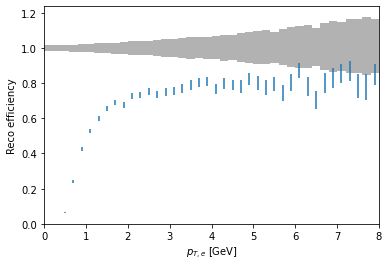

<Figure size 432x288 with 0 Axes>

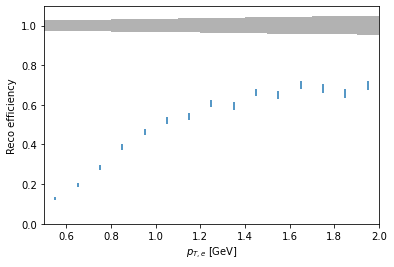

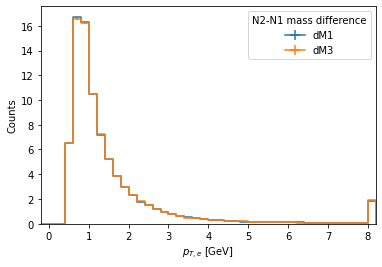

In [315]:
plt.figure()
hist.plotratio(num=result["pt_all_truth_matched"].integrate("dataset"), 
               denom=result["pt_all_truth"].integrate("dataset")) #, error_opts={"marker": "x"})
plt.ylabel("Reco efficiency")
plt.figure()
hist.plotratio(num=result["pt_all_truth_matched_sm"].integrate("dataset"), 
               denom=result["pt_all_truth_sm"].integrate("dataset")) #, error_opts={"marker": "x"})
plt.ylabel("Reco efficiency")


plt.figure()
hist.plot1d(result["pt_all_reco_unmatched"],overflow='all')


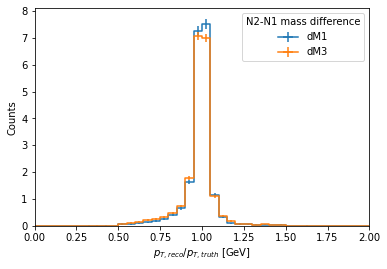

In [316]:
#hist.plot2d(result['pt_rel'].sum('dataset'),xaxis='pt')
hist.plot1d(result['pt_rel'].sum('pt'),density=True)

Now try things with the reco objects

prompt
{(): array([  1.,   1., 189., 574., 833., 884., 816., 762., 666., 588., 503.,
       477., 437., 338., 297., 287., 232., 204., 221., 214., 175., 150.,
       162., 123., 112.,  92.,  87., 102.,  72.,  65.,  69.,  55.,  60.,
        49.,  40.,  47.,  41.,  35.,  32.,  39.])}
{(): array([  1.,   1., 203., 626., 891., 935., 869., 816., 730., 628., 535.,
       510., 461., 366., 317., 302., 254., 223., 241., 216., 185., 158.,
       171., 130., 121., 101.,  90., 107.,  77.,  68.,  71.,  59.,  67.,
        50.,  46.,  50.,  43.,  38.,  33.,  42.])}
loose
{(): array([  0.,   0.,   2.,  18.,  70., 179., 259., 307., 333., 317., 318.,
       337., 312., 265., 254., 227., 193., 177., 193., 189., 162., 136.,
       148., 111., 106.,  81.,  83.,  96.,  69.,  64.,  67.,  51.,  58.,
        48.,  40.,  44.,  40.,  34.,  31.,  39.])}
{(): array([  1.,   1., 203., 626., 891., 935., 869., 816., 730., 628., 535.,
       510., 461., 366., 317., 302., 254., 223., 241., 216., 185., 158.,
       171.

ValueError: Found numerator larger than denominator while calculating binomial uncertainty

<Figure size 432x288 with 0 Axes>

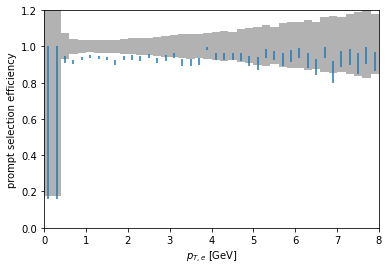

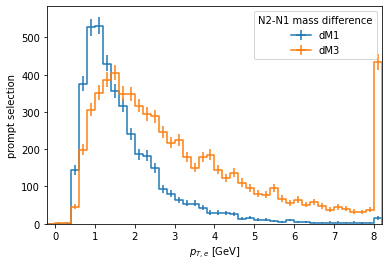

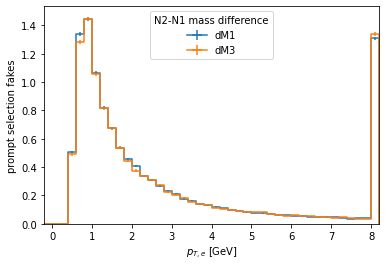

<Figure size 432x288 with 0 Axes>

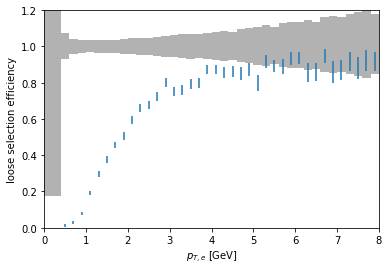

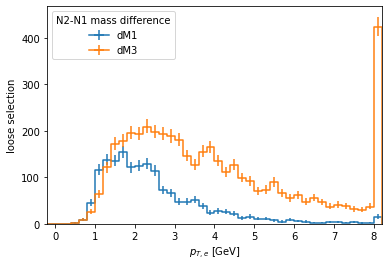

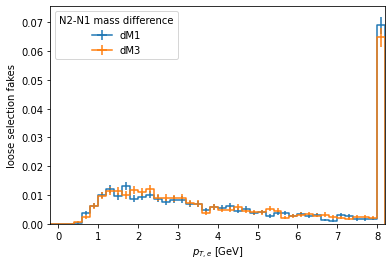

<Figure size 432x288 with 0 Axes>

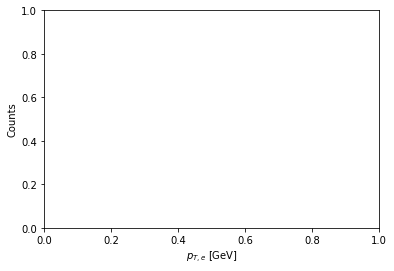

In [321]:
#selections=['prompt','loose']

for sel in selections:
    if True:
        plt.figure()
        print(sel)
        print(result[sel+"_pt_all_truth_selected"].integrate("dataset").values())
        print(result["pt_all_truth_matched"].integrate("dataset").values())
        hist.plotratio(num=result[sel+"_pt_all_truth_selected"].integrate("dataset"), 
                   denom=result["pt_all_truth_matched"].integrate("dataset")) #, error_opts={"marker": "x"})
        plt.ylabel(sel+" selection efficiency")
        ax = plt.gca()
        ax.set_ylim(0.,1.2)
    #plt.figure()
    #hist.plotratio(num=result["pt_all_truth_matched_sm"].integrate("dataset"), 
    #           denom=result["pt_all_truth_sm"].integrate("dataset")) #, error_opts={"marker": "x"})
    #plt.ylabel("Reco efficiency")

    plt.figure()
    hist.plot1d(result[sel+"_pt_all_truth_selected"],overflow='all')
    plt.ylabel(sel+" selection")

    plt.figure()
    hist.plot1d(result[sel+"_pt_all_selected_unmatched"],overflow='all')
    plt.ylabel(sel+" selection fakes")
    #20k, 3k max



In [ ]:
truthMatched = (events.ElectronBPark.genPartIdx >=0)
real_reco = events.ElectronBPark[truthMatched]
fake_reco = events.ElectronBPark[~truthMatched]
#real_reco.counts
#real_reco.genPartIdx #.distincts()
real_reco_matches = events.GenPart[ real_reco.genPartIdx ]
isDM1 = (dM<2)[:,0]
#events.GenPart[ real_reco ]
#fake.counts
real_reco_masked = real_reco[mask]
#real_reco_masked[isDM1].pt
#help(truth_eles)

#how to check whether a genParticle matches a BPark ele?
#truth_ele_mask
#real_reco_matches
#real_reco.genPartIdx.argcross( events.GenPart[truthMatched] )
#truthMatched.argmatch(truthMatched)
#events.GenPart
#real_reco.genPartIdx.argcross( events.GenPart[truthMatched] )
#real_reco.genPartIdx.
#unique_genIdx = ak.fromiter([list(set(x)) for x in real_reco.genPartIdx.tolist()])
#l = [list(set(ll)) for ll in l]
#real_reco

In [175]:
truth_ele_mask = (abs(events.GenPart.pdgId) == 11) & events.GenPart.hasFlags(['isPrompt', 'isLastCopy'])
all_truth_eles = events.GenPart[truth_ele_mask]
# get ee events
event_mask = (all_truth_eles.counts==2)
truth_eles = all_truth_eles[event_mask]

#match truth_eles
reco_eles = events.ElectronBPark #[event_mask]
# cut down on combinatorics by picking out the 'good ones' first
reco_eles_prematched = reco_eles[events.ElectronBPark.genPartIdx >=0]
reco_eles_prematched = reco_eles_prematched[event_mask]
tr_pairs = truth_eles.cross(reco_eles_prematched, nested=True)
t, r = tr_pairs.unzip()
drs = t.delta_r(r)
idx = drs.argmin()
r_match = tr_pairs.i1[idx[drs[idx] < 0.05]]
t_match = tr_pairs.i0[idx[drs[idx] < 0.05]]

#print(reco_eles_prematched.size)
#print(r_match.size)
#print(t_match.size)
print(t_match.flatten(1).size)
print(t_match.size)
n=3
print(reco_eles_prematched[:n].counts)
print(truth_eles[:n].counts)
#print(reco_eles_prematched[:n])
#print(truth_eles[:n])
print(r_match[:n])
print(t_match[:n])
print(r_match.flatten(1)[:n])

#print(tr_pairs[:n].summary)
#idx

#matched_t.flatten()
#isDM1 = (dM<2)[:,0]
#t_match[isDM1] #.pt.flatten()




14281
14281
[1 0 5]
[2 2 2]
[[[<ElectronBPark 17>] []] [[] []] [[<ElectronBPark 439>] []]]
[[[<GenPart 23>] []] [[] []] [[<GenPart 319>] []]]
[[<ElectronBPark 17>] [] [<ElectronBPark 439>]]


In [192]:
#genEleIndices = events.GenPart.pt.localindex[truth_ele_mask]
f = lambda x: (np.abs(x.dz) < 0.2) & (x.sip3d < 3)
id_mask = f(reco_eles)
reco_eles[id_mask]

#help(events.ElectronBPark) #.argmatch(events.genPart)
#truthMatched

<JaggedArray [[<ElectronBPark 1> <ElectronBPark 3> <ElectronBPark 5> ... <ElectronBPark 18> <ElectronBPark 22> <ElectronBPark 60>] [<ElectronBPark 64> <ElectronBPark 65> <ElectronBPark 66> ... <ElectronBPark 146> <ElectronBPark 152> <ElectronBPark 169>] [<ElectronBPark 172> <ElectronBPark 174> <ElectronBPark 175> ... <ElectronBPark 233> <ElectronBPark 238> <ElectronBPark 252>] ... [<ElectronBPark 2131170> <ElectronBPark 2131171> <ElectronBPark 2131172> ... <ElectronBPark 2131223> <ElectronBPark 2131224> <ElectronBPark 2131239>] [<ElectronBPark 2131260>] [<ElectronBPark 2131287> <ElectronBPark 2131289> <ElectronBPark 2131294> ... <ElectronBPark 2131313> <ElectronBPark 2131352> <ElectronBPark 2131357>]] at 0x00013e579518>